## Title: Binary Classification with a Bank Churn Dataset

#### Goal: In this notebook, I'll predict whether a customer continues with their account or closes it.[Exited]

`Author`: Abdul Muid 

`Github`: [abdul-muid](https://github.com/abdul-muid/)\
`Linkedin`: [abdulmuid](https://www.linkedin.com/in/abdulmuid/)

Dataset Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

In [27]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# To Preprocess the data
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Machine learning
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Classification 
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [28]:
# Lets import the dataset
df = pd.read_csv('train.csv')
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Dataframe Info

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


### Summary Statistics

In [30]:
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


# Exploratory Data Analysis

### Unique Value in Each categorical column

In [31]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(col, df[col].unique())

Surname ['Okwudilichukwu' 'Okwudiliolisa' 'Hsueh' ... 'Aliyev' 'McMinn' 'Elkins']
Geography ['France' 'Spain' 'Germany']
Gender ['Male' 'Female']


### Finding Missing Values

In [32]:
df.isnull().sum() / len(df) * 100

id                 0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Finding Outliers

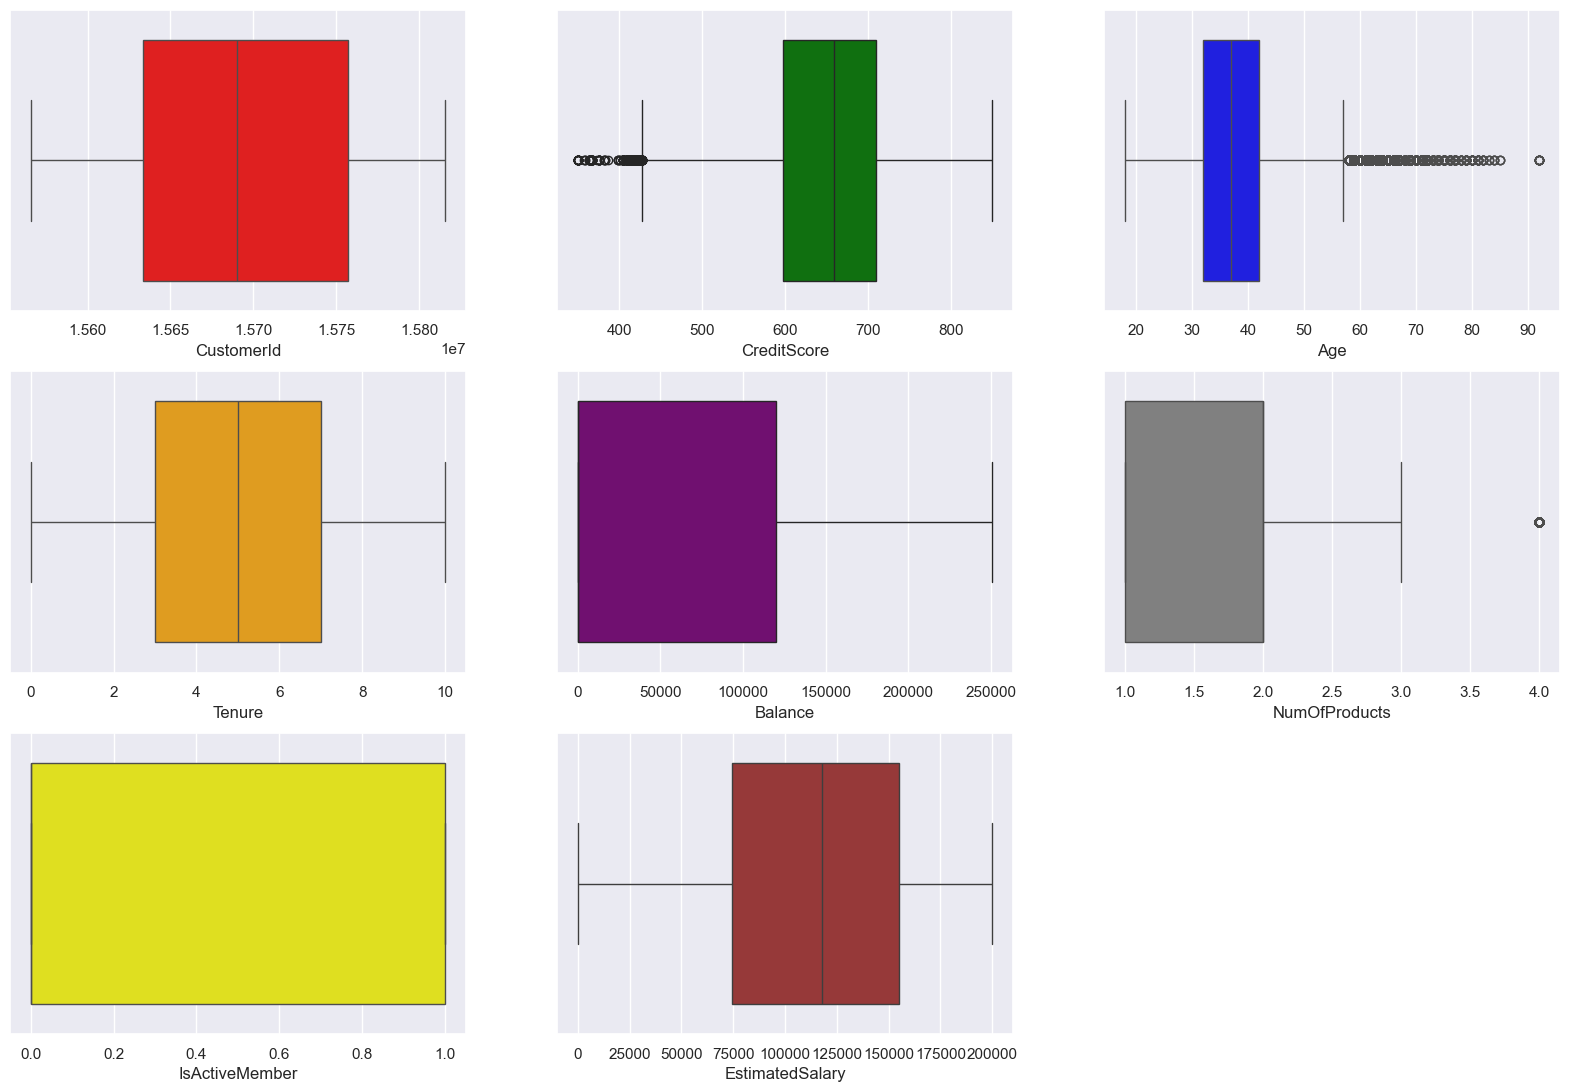

In [33]:
numerical_columns = [col for col in df.columns if df[col].dtype != 'object' and col != 'id' and col != 'Exited' and col != 'HasCrCard']  

plt.figure(figsize=(20, 18))

colors = ['red', 'green', 'blue','orange', 'purple', 'grey', 'yellow', 'brown',]

for i, col in enumerate(numerical_columns):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x = df[col], color = colors[i])
plt.show()

- There are few outliers in CreditScore column, but we wil not remove them as they provide some info

### Data Distributions

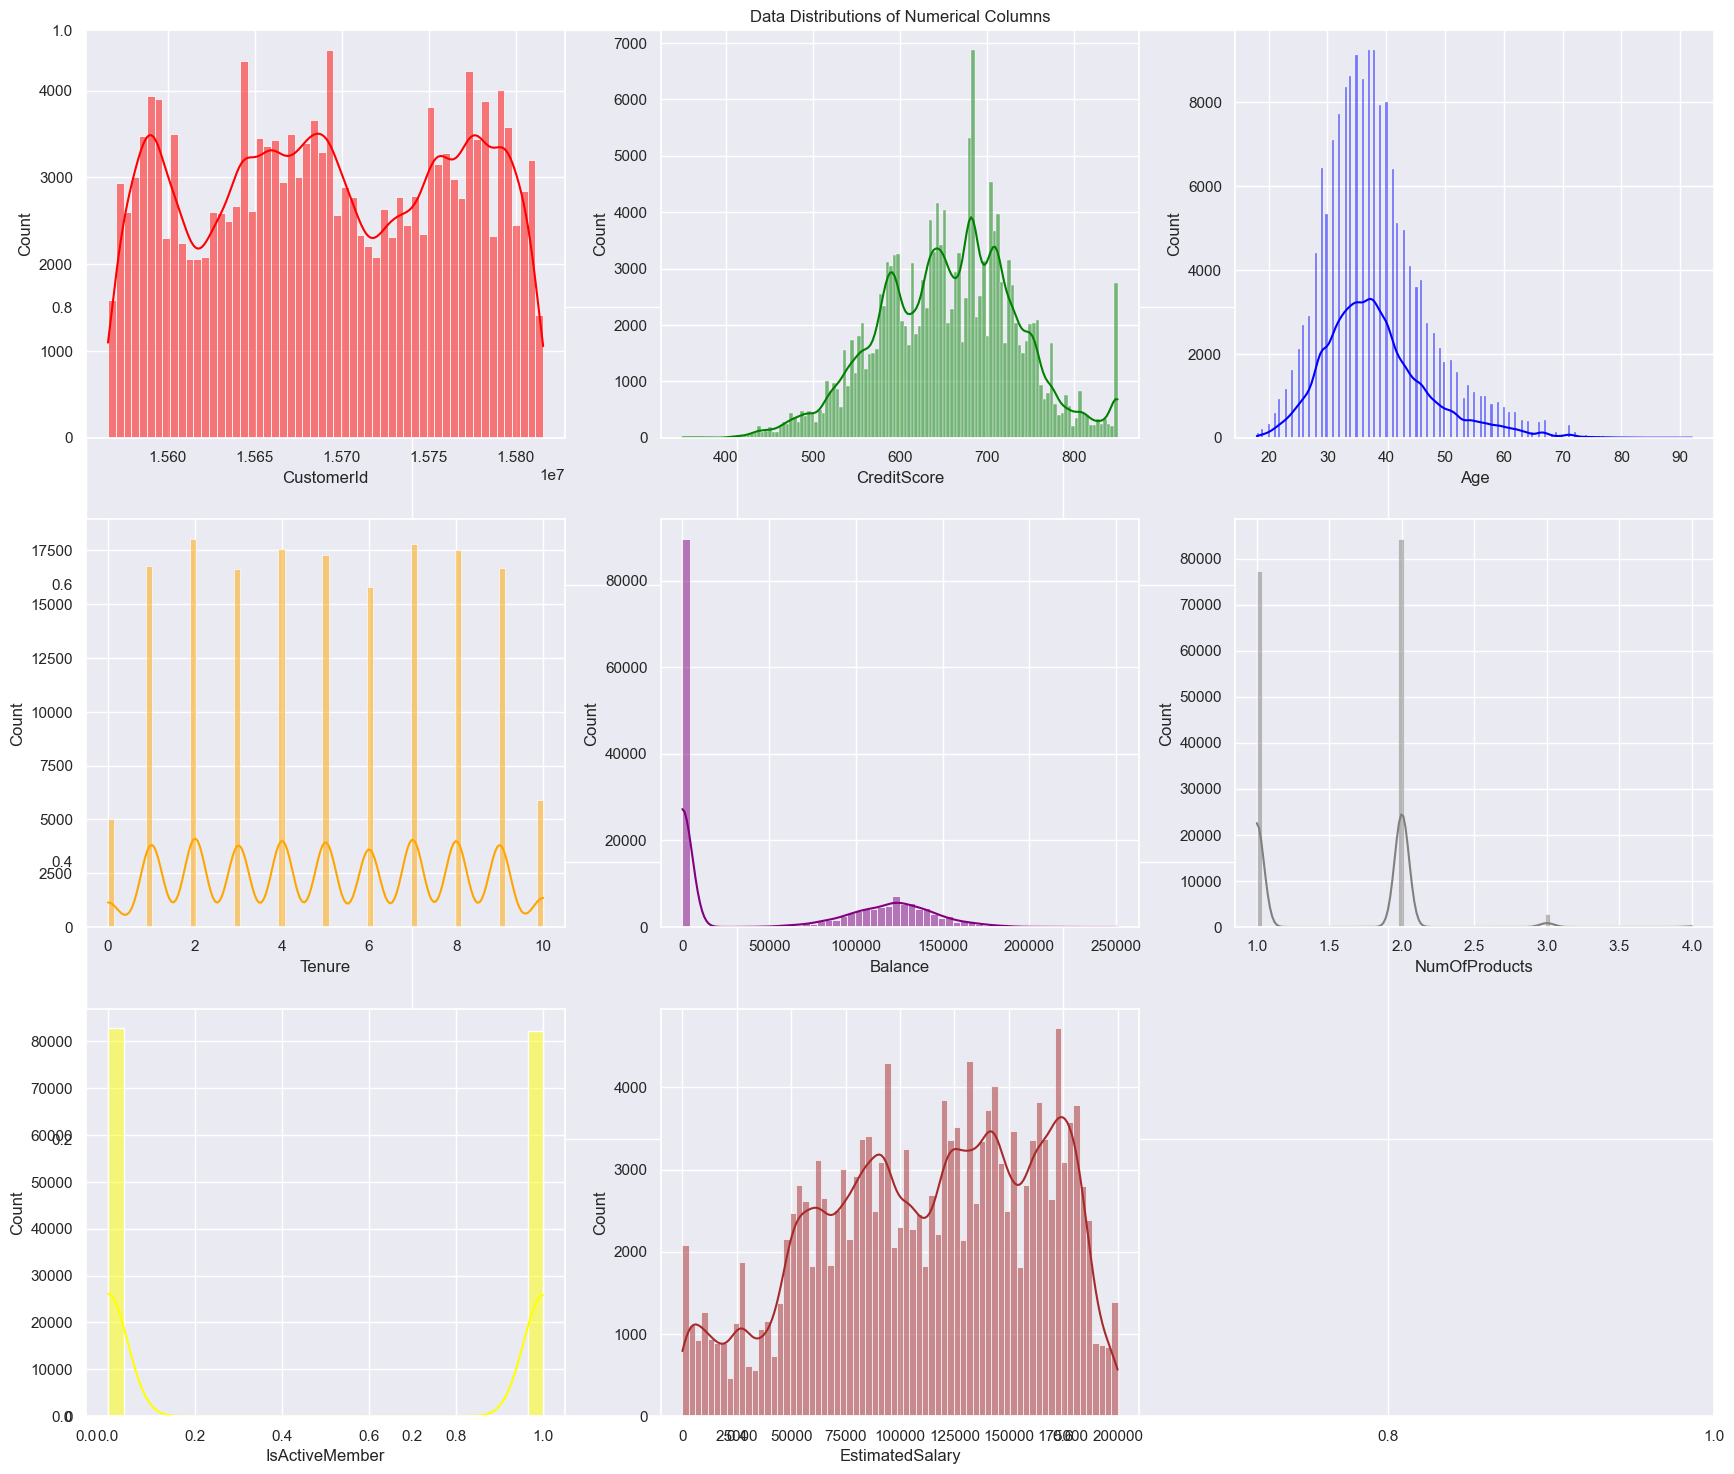

In [34]:
plt.figure(figsize=(21, 18))

colors = ['red', 'green', 'blue','orange', 'purple', 'grey', 'yellow', 'brown']
plt.title("Data Distributions of Numerical Columns") 
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(x = df[col], color = colors[i], kde=True)
plt.show()

- The Age column is right skewed. 
- We have imbalance in NumOfProducts and Balance columns


### Lets Create a Correlation Matrix 

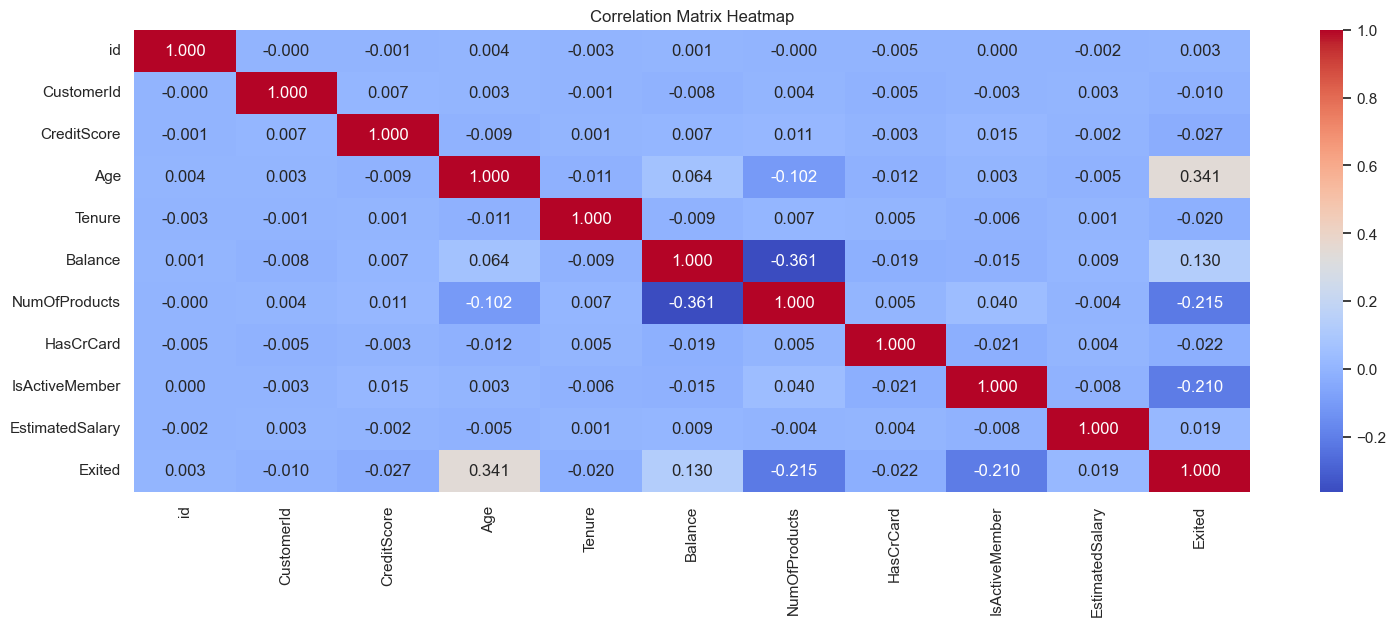

In [35]:
cor_columns = ['id',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

correlation_matrix  = df[cor_columns].corr()
plt.figure(figsize=(18, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix Heatmap')
plt.show()

### Lets Explore the following Columns and find useful insights

Gender
Female    656.243726
Male      656.616930
Name: CreditScore, dtype: float64


<Axes: xlabel='Gender', ylabel='CreditScore'>

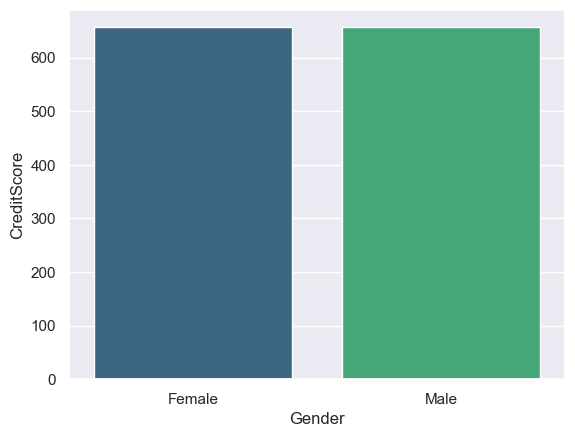

In [36]:
# Lets calculate the average credit score grouped by gender.
print(df.groupby('Gender')['CreditScore'].mean())
sns.barplot(df.groupby('Gender')['CreditScore'].mean(), palette='viridis')

Gender  Geography
Female  France       655.929433
        Germany      657.140774
        Spain        656.106057
Male    France       656.157341
        Germany      656.721923
        Spain        657.729135
Name: CreditScore, dtype: float64


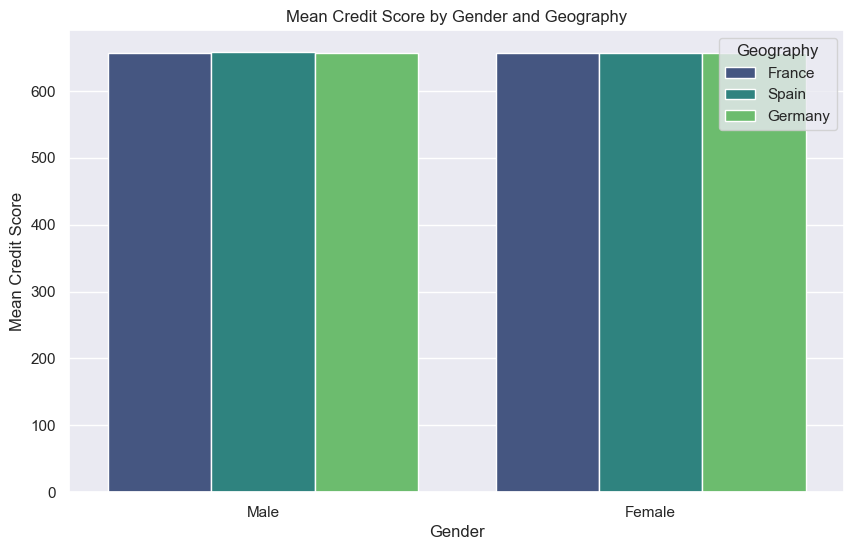

In [37]:
# Average Credit Score Grouped by Gender and Geography
print(df.groupby(['Gender', 'Geography'])['CreditScore'].mean())
plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='CreditScore', hue='Geography', data=df, estimator='mean', ci=None, palette='viridis')
plt.title('Mean Credit Score by Gender and Geography')
plt.xlabel('Gender')
plt.ylabel('Mean Credit Score')
plt.show()

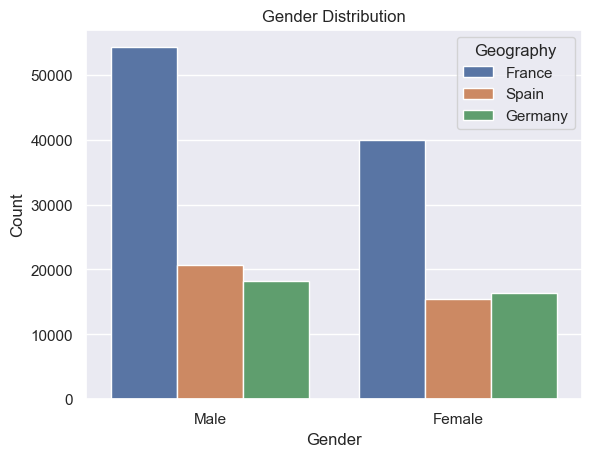

In [38]:
sns.countplot(x='Gender', data=df, hue='Geography')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Gender  Geography  HasCrCard
Female  France     1.0          30170
                   0.0           9806
        Germany    1.0          12285
                   0.0           4103
        Spain      1.0          11516
                   0.0           4004
Male    France     1.0          41421
                   0.0          12818
        Germany    1.0          13662
                   0.0           4556
        Spain      1.0          15374
                   0.0           5319
Name: count, dtype: int64


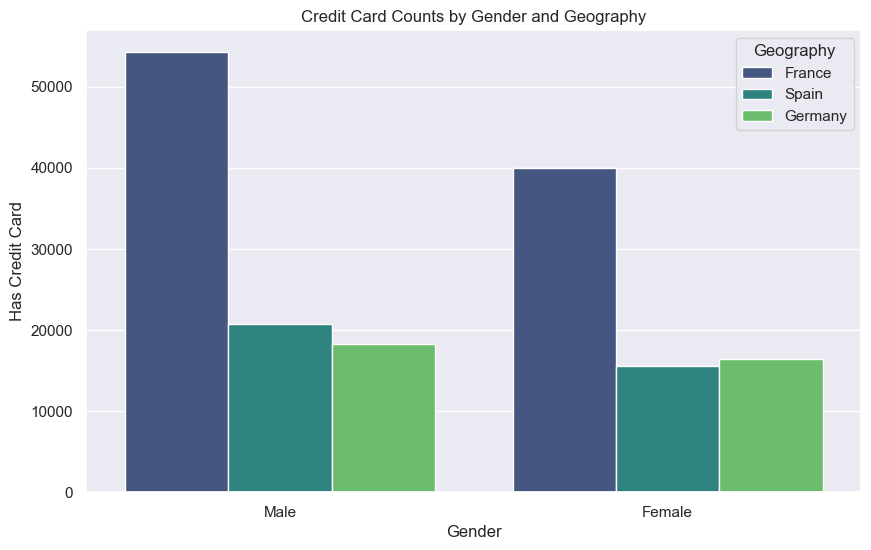

In [39]:
print(df.groupby(['Gender', 'Geography'])['HasCrCard'].value_counts())

plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='HasCrCard', hue='Geography', data=df, estimator='count', ci=None, palette='viridis')
plt.title('Credit Card Counts by Gender and Geography')
plt.xlabel('Gender')
plt.ylabel('Has Credit Card')
plt.show()

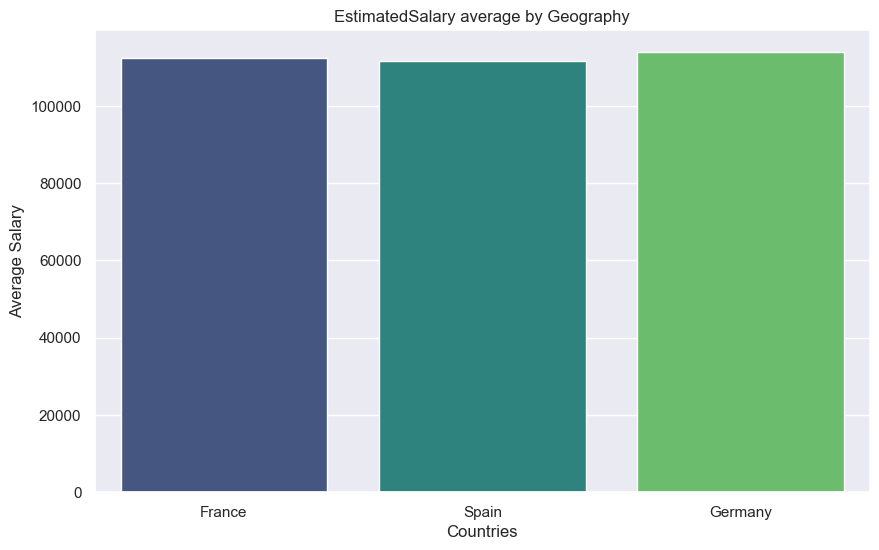

In [40]:
df.groupby('Geography')['EstimatedSalary'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x='Geography', y='EstimatedSalary', hue='Geography', data=df, estimator='mean', ci=None, palette='viridis')
plt.title('EstimatedSalary average by Geography')
plt.xlabel('Countries')
plt.ylabel('Average Salary')
plt.show()

Text(0.5, 1.0, 'Box Plot')

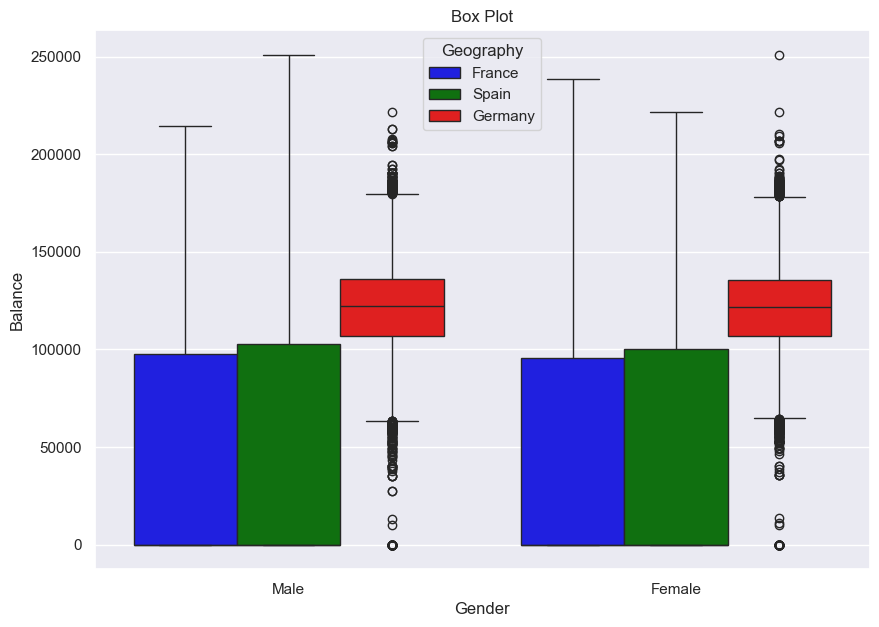

In [41]:
# Box Plot 
sns.set_theme(style='darkgrid')
plt.figure(figsize=(10,7))
palletes = {'Spain': 'green', 'Germany': 'red', 'France': 'blue'}
sns.boxplot(df, x='Gender', y='Balance', hue='Geography', palette=palletes)

# Labels
plt.xlabel('Gender')
plt.ylabel('Balance')
plt.title('Box Plot')

<span style="color: teal; font-size: 300%; font-weight: bold;">Outputs</span>

- There is more data of males than female in the dataset
- Most of the males in France have credit card
- There is no difference in credit score of male vs female
- On average credit score is similar for male and female in all the given countries. 
- The distribution of credit card ownership is relatively similar across countries.
- The average estimated salary in Germany is slightly higher than in France and Spain


---

<span style="color: teal; font-size: 300%; font-weight: bold;">Machine Learning</span>

In [42]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [43]:
# Split Data

X = df.drop('Exited', axis = 1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Lets create a Pipeline 

c_col = [col for col in X.columns if X[col].dtype == 'object']
n_col = [col for col in X.columns if col not in c_col]

print(c_col)
print(n_col)

['Surname', 'Geography', 'Gender']
['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [45]:
# Categorical Transformer
c_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Numerical Transformer
n_transformer = Pipeline(steps=[
    ('scalar', MinMaxScaler())
])

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', c_transformer, c_col),
    ('num', n_transformer, n_col)
])

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', XGBClassifier())
])

In [50]:
# Hyperparameter Tuning

param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_features': ['sqrt', 'log2'],
    'estimator__max_depth': [4, 7, 10],
    'estimator__criterion': ['squared_error', 'friedman_mse'],
}

In [51]:
# Lets Create a Grid 

# Using StratifiedKfold, this will ensure each fold maintains the same class distribution as the entire dataset. 

skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid= param_grid,
    cv = skf,
    scoring='accuracy',
    verbose=1,
    n_jobs=1
)

In [52]:
# Lets Fit the Model

grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Surname',
                                                                          'Geography',
                                                                          'Gender']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scalar',
                                                                                          MinMaxScaler())]),
                                                                         ['id',
                                                                          'CustomerId',
                                                                          'CreditScore',
                                                                          'Age',
                                                                          'Te...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=1,
             param_grid={'estimator__criterion': ['squared_error',
                                                  'friedman_mse'],
                         'estimator__max_depth': [4, 7, 10],
                         'estimator__max_features': ['sqrt', 'log2'],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [53]:
# Predicting the test data
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

In [54]:
# Metrics

print((classification_report(y_test, y_pred)))
print()
print("Accuracy Score", accuracy_score(y_test ,y_pred))
print("F1 Score ", f1_score(y_test, y_pred))
print("Recall Score ", recall_score(y_test, y_pred))
print("Precision Score ", precision_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26052
           1       0.75      0.57      0.65      6955

    accuracy                           0.87     33007
   macro avg       0.82      0.76      0.78     33007
weighted avg       0.86      0.87      0.86     33007


Accuracy Score 0.8696943072681552
F1 Score  0.6481799591002044
Recall Score  0.5696621135873472
Precision Score  0.7518026565464896


In [55]:
# Accuracy Score 0.8696943072681552
# F1 Score  0.6481799591002044
# Recall Score  0.5696621135873472
# Precision Score  0.7518026565464896

<span style="color: teal; font-size: 300%; font-weight: bold;">Outputs</span>


`Accuracy (0.8697):`

87% correctness in predictions.

`F1 Score (0.6482):`

Balanced precision and recall, indicating solid model performance.

`Recall (0.5697):`

Captures 57% of actual positive instances.

`Precision (0.7518):`

75% accuracy in positive predictions.

In [56]:
best_model = grid.best_estimator_

Lets Predict the test set

In [57]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [58]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [59]:
predictions = best_model.predict_proba(df_test)
submission['Exited'] = predictions[:, 1]
submission.to_csv('submission_01.csv', index = False)